In [46]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

In [26]:
logins_df = pd.read_json('Downloads/logins.json')

In [172]:
with open('./ultimate_data_challenge.json') as f:
    data = json.load(f)

ultimate_df = pd.DataFrame(data)
ultimate_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


# Part 1

In [27]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [32]:
logins_df.dtypes
#so login is datetime object so should be able to aggregate 

login_time    datetime64[ns]
dtype: object

In [34]:
logins_df.describe()
#not sure if these times are in order since first is 20:12 but table shows 20:13

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [37]:
logins_df = logins_df.sort_values('login_time')
logins_df.head()
#now looks in order. since we need to aggregate into 15 minute blocks, need to use time delta 
#since we need to see trends in the times, it makes sense to create a new column with the counts

,login_time
6,1970-01-01 20:12:16
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
3,1970-01-01 20:16:36
2,1970-01-01 20:16:37


In [39]:
time_c = pd.date_range('1970-01-01 20:00:00', '1970-04-13 19:00:00', freq='15T')
ts = pd.Series(np.zeros(len(time_c)), index=time_c)
#created a series that ranges the length of time of the data, but is broker into 15mm intervals
#this has been pre-filled for 0.00 so that I can count how many fall into each bucket

In [40]:
ts.head()

1970-01-01 20:00:00    0.0
1970-01-01 20:15:00    0.0
1970-01-01 20:30:00    0.0
1970-01-01 20:45:00    0.0
1970-01-01 21:00:00    0.0
Freq: 15T, dtype: float64

In [43]:
p = 0 
for i in range(len(logins_df)):
    s = ts.index[p] 
    e = ts.index[p+1] 
    t = logins_df['login_time'][i]
    if s < t < e:
        ts[p] = ts[p] + 1
    else:
        while (e < t):
            p = p + 1 
            s = ts.index[p] 
            e = ts.index[p+1]
        ts[p] = ts[p] + 1

In [44]:
ts.head()
#so now we have a column that has the frequency of actual logins that fell into that specific 15 minute increment - we can do some EDA on this 

1970-01-01 20:00:00     1.0
1970-01-01 20:15:00     6.0
1970-01-01 20:30:00     2.0
1970-01-01 20:45:00    15.0
1970-01-01 21:00:00     0.0
Freq: 15T, dtype: float64

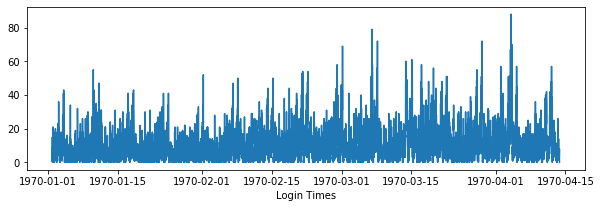

In [51]:
fig = plt.figure(figsize=(10,3))
_ = plt.xlabel('Login Times')
_ = plt.plot(ts)
plt.show()
#so we can see by looking at the below graph that there was a spike after 4/1/1970 also similar spike between 3/1 and 3/15

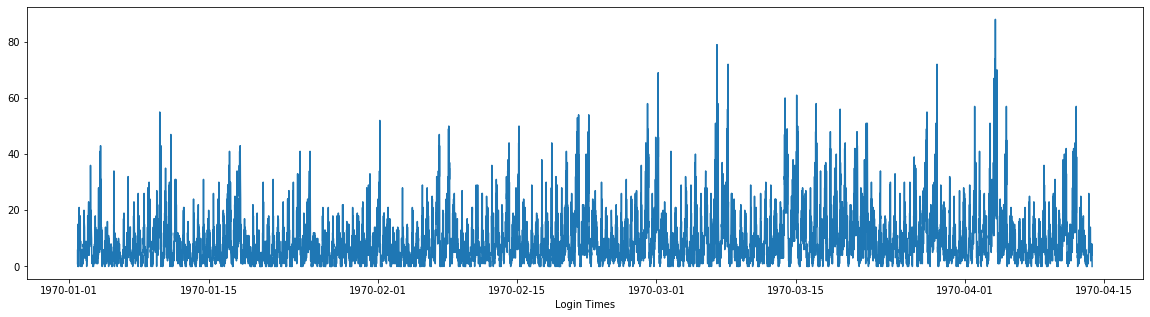

In [55]:
fig = plt.figure(figsize=(20,5))
_ = plt.xlabel('Login Times')
_ = plt.plot(ts)
plt.show()

In [54]:
ts.sort_values().tail()
#looking at the values sorted - we can see the spikes were 4/4 and 3/7 respectively 
#4/4 was as a saturday and fig = plt.figure(figsize=(10,3))
_ = plt.xlabel('Login Times')
_ = plt.plot(ts)
plt.show()3/7 was also a saturday so pikes occurred on weekends which makes sense 

1970-03-29 05:00:00    72.0
1970-03-08 05:00:00    72.0
1970-04-04 00:45:00    74.0
1970-03-07 02:15:00    79.0
1970-04-04 01:45:00    88.0
dtype: float64

# Part 2

# 1.What    would     you     choose     as     the     key    measure    of     success    of     this    experiment     in  encouraging    driver     partners     to     serve    both     cities,    and    why    would     you     choose     this    metric?  

#some facts Gotham is most active at night, metro more active during the day. both active on weekends. there is a toll bridge between two cities with a two way toll - proposal to reimburse toll costs to driver partners

1a. A key measure of success for this problem would be an increase of crosses on the toll bridge because this would show that more drivers are going between gotham and metro, so this should be increasing driver availability

# 2.Describe    a    practical     experiment     you    would    design     to     compare     the    effectiveness    of     the  proposed     change     in     relation     to     the     key    measure    of     success.   

2a. An experiment that could be done to measure the effectiveness of the change would be to document the toll charges prior to ennacting the change, and then once the change has been made, document the amount of toll charges to see if they have spiked. Since these are reimbursements, the drivers will still be charged at first and then will later be reimbursed, so we would expect a spike in charges as drivers should be more motivated to cross the bridge. This could be a two week experiment, first week without reimbursements and second week with reimbursements

2b. Since we want to see two different scenarios, the amount of crosses with reimbursements and without reimbursements, A/B testing seems like the best option because you will create two identical scenarios but change the toll reimbursements to determine the impact that has on the number of crosses. This would allow us to then use Bayesian methods to see if implementing a toll reimbursement will have an impact. We will set the no reimbursement as the prior belief since that is our baseline. 

2c. With this data I would want to perform a Bayesian simulation with reimbursement against no reimbursement (each being a one week period). We could compare the amount of rides over that period and then could create a simulated data set so that we could randomize the samples and see the significance. This would allows to consider other factors and account for outliers. This would help us to determine if there is any signficance in the reimbursements, and from there we could create a predictive model to see the long-term effects reimbursements will have

# Part 3

In [56]:
#notes: what factors are best predictors for retention and can be used by Ultimate
#user retained if they took a trip in preceding 30days
ultimate_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [58]:
#1 going to begin EDA of data-set to see if missing data and fraction of retained usuers
ultimate_df.describe()
#we can see the count of rides is 50,000 but some nans values 

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [60]:
ultimate_df.isna().any()
#so looking at nans we have some in avg_rating by driver, avg_rating of driver, and phone, lets see how many

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
dtype: bool

In [64]:
ultimate_df['phone'].isna().sum()
#this value of nans are pretty low so may just drop

396

In [65]:
ultimate_df['avg_rating_by_driver'].isna().sum()
#this value of nans are pretty low so may just drop

201

In [66]:
ultimate_df['avg_rating_of_driver'].isna().sum()
#this nan is pretty high so wouldn't want to drop these values 
#i don't want to drop these because may be helpful in determining factors for retention

8122

In [67]:
ultimate_df['avg_rating_of_driver'].describe()
#i am going to leave the nans for now because these may be important predictor variables 

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [80]:
ultimate_df.groupby('ultimate_black_user').count()
#we can see that false ultimate black user is 30,827 but true is 18,579

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,weekday_pct
ultimate_black_user,,,,,,,,,,,
False,30827,30827,30827,30827,30827,30827,30827,30827,30827,30827,30827
True,18579,18579,18579,18579,18579,18579,18579,18579,18579,18579,18579


In [81]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  49406 non-null float64
avg_rating_by_driver      49406 non-null float64
avg_rating_of_driver      49406 non-null float64
avg_surge                 49406 non-null float64
city                      49406 non-null object
last_trip_date            49406 non-null object
phone                     49406 non-null object
signup_date               49406 non-null object
surge_pct                 49406 non-null float64
trips_in_first_30_days    49406 non-null int64
ultimate_black_user       49406 non-null bool
weekday_pct               49406 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [105]:
ultimate_df[['signup_date', 'last_trip_date']].describe()
#since we need to see if a user was active 6months after signing up, we will need to use these columns to determine if a ride was taken
#but the last trip date and signup date are not integers so may need to fix that 

,signup_date,last_trip_date
count,49406,49406
unique,31,182
top,2014-01-18,2014-06-29
freq,2915,2016


In [102]:
ultimate_df['signup_date'][0]

'2014-01-25'

In [107]:
#creating a for loop that will go through the dataframe and if a trip was taken
#within 6 months of the first ride, it will add a 1 to show that the user is considered active
active_users = []
for i in range(len(ultimate_df)):
    st = pd.Timestamp(ultimate_df['signup_date'][i]) 
    et = st + pd.Timedelta('181D')
    at = et - pd.Timedelta('30D') 
    if at <= pd.Timestamp(ultimate_df['last_trip_date'][i]) <= et:
        active_users.append([1]) 
    else:
        active_users.append([0])

In [133]:
active_usersdf = pd.DataFrame(active_users)
#since i created a list of the active_users, converting to a dataframe

In [134]:
active_usersdf.head()

,0
0,0
1,0
2,0
3,1
4,0


In [135]:
active_usersdf[0].value_counts()
#looking at the amount of active users, we can see that 37,000 are not active
#and 12000 are active

0    37802
1    12198
Name: 0, dtype: int64

In [145]:
#fraction of users retained: 
12198/50000 *100

24.396

In [173]:
#want to look at some trends with active users
ultimate_df['active_users'] = active_users
#i have created a new column of active users and appending to current datafram to use for EDA 

In [174]:
ultimate_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_users
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
active_users,,,,,,,,
0,230382.44,179982.2,140692.9,40598.30,327224.9,69438,12598.0,2298734.0
1,59458.89,57965.3,52011.2,13139.89,115251.9,44472,6256.0,747570.2


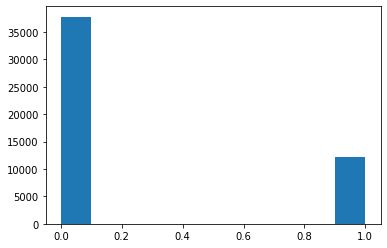

In [183]:
_ = plt.hist(ultimate_df['active_users'])

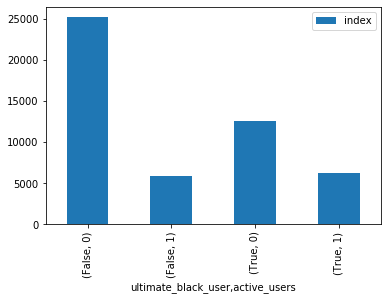

In [192]:
#going to compare the active users against if they are ultimate black user
ultimate_df1 = ultimate_df[['ultimate_black_user', 'active_users']]
ultimate_df1.reset_index().groupby(['ultimate_black_user', 'active_users']).count().plot(kind='bar')
#looking at the distribution, the amount that were retained are pretty equal between ultimate black users and non, so don't see this as a leading indicator

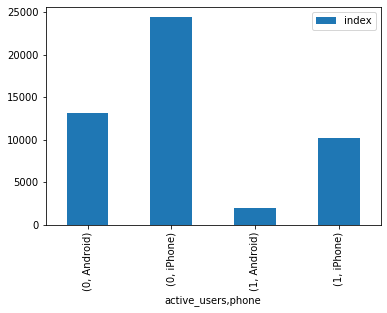

In [213]:
ultimate_df1 = ultimate_df[['phone', 'active_users']]
ultimate_df1.reset_index().groupby(['active_users', 'phone']).count().plot(kind='bar')
#also does not look like any strong trends with phone type 

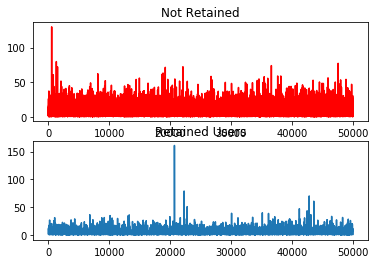

In [230]:
ultimate_df2 = ultimate_df[ultimate_df.active_users == 1]
ultimate_df3 = ultimate_df[ultimate_df.active_users == 0]
plt.subplot(2,1,2)
plt.plot(ultimate_df2['avg_dist'])
plt.title('Retained Users')
plt.subplot(2,1,1)
plt.plot(ultimate_df3['avg_dist'], color='red')
plt.title('Not Retained')
plt.show()
#comparing the avg distance of the retained users verse not-retained it looks like overall average is lower for retained customers but larger spikes for them as well for 

In [238]:
np.mean(ultimate_df2['avg_dist'])

4.874478603049706

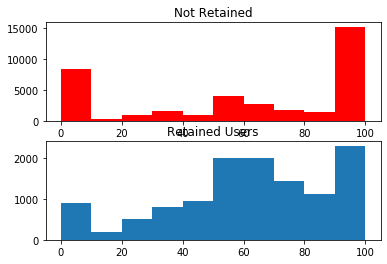

In [233]:
#also want to compare the weekday percentage for retained and not-retained
plt.subplot(2,1,2)
plt.hist(ultimate_df2['weekday_pct'])
plt.title('Retained Users')
plt.subplot(2,1,1)
plt.hist(ultimate_df3['weekday_pct'], color='red')
plt.title('Not Retained')
plt.show()
#looks like overall trend is similar as both active and not active have large weekday percentages
#there is a higher spike from 50-70 percent for active though

In [236]:
ultimate_df.groupby('city').count()
#so looking that the cities, there are three main ones so I am going to see if there is any connection to the these and if users are retained

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_users
city,,,,,,,,,,,,
Astapor,16534,16476,13647,16534,16534,16413,16534,16534,16534,16534,16534,16534
King's Landing,10130,10090,8847,10130,10130,10066,10130,10130,10130,10130,10130,10130
Winterfell,23336,23233,19384,23336,23336,23125,23336,23336,23336,23336,23336,23336


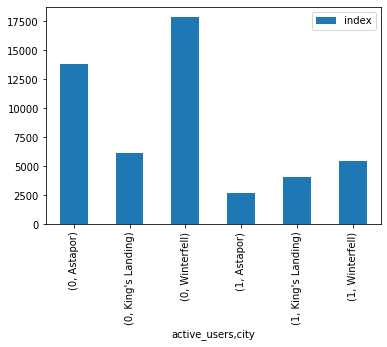

In [237]:
#lastly want to take a look at the cities to see if there are any trends
ultimate_df1 = ultimate_df[['city', 'active_users']]
ultimate_df1.reset_index().groupby(['active_users', 'city']).count().plot(kind='bar')
#looks like the highest retained users were from winterfell and king's landing but also winterfell had a high amount of non-retained

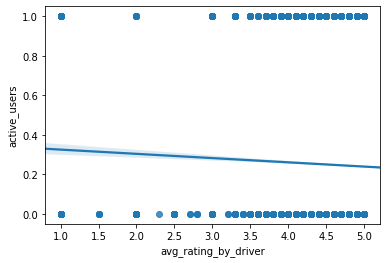

In [241]:
#want to run a scatter plot of active users and different variables to see correlation but can't figure out how to fit this in matplotlib. seaborn has a fit_reg option so will be using that 
import seaborn as sns
sns.regplot(y=ultimate_df['active_users'], x=ultimate_df['avg_rating_by_driver'], fit_reg=True)
#doesn't seem like too strong of a relationship between rating by driver and user retention

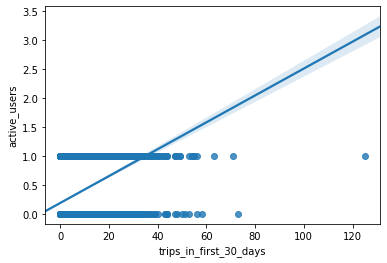

In [242]:
sns.regplot(y=ultimate_df['active_users'], x=ultimate_df['trips_in_first_30_days'], fit_reg=True)
#does look like a moderately strong relationship between rides taken in first 30days and retention

# Builing predictive model

In [245]:
#build model to determine whether or not a user will be active in their 6th month
#factors to consider (trips in first 30 days, avg rating by driver, city, phone, avg dist)
#going to start with a linear regression for trips in 30 days and active user
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
m = ols('trips_in_first_30_days ~ active_users', ultimate_df).fit()
print(m.summary())
#ran an OLs to get some idea of the relationship. R squared is very low so indicating that model is not fitting well 

                              OLS Regression Results                              
Dep. Variable:     trips_in_first_30_days   R-squared:                       0.042
Model:                                OLS   Adj. R-squared:                  0.042
Method:                     Least Squares   F-statistic:                     2190.
Date:                    Mon, 30 Mar 2020   Prob (F-statistic):               0.00
Time:                            19:21:29   Log-Likelihood:            -1.3653e+05
No. Observations:                   50000   AIC:                         2.731e+05
Df Residuals:                       49998   BIC:                         2.731e+05
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercep

In [249]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
X = ultimate_df['trips_in_first_30_days']
y = ultimate_df['active_users']
X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = (lr.predict(X_test))
r2_score(y_test, y_pred)
#so ran through linear regression and still getting very low r squared so not fitting data well 
#there are some nans as I had identified earlier and did not drop. I am going to code drop the nans for the  

0.03995797787756117

In [311]:
ultimate = ultimate_df
ultimate = ultimate.dropna(subset = ['phone', 'avg_rating_by_driver'])
#the majority of nans were in avg_rating_of_driver which is not a column i'm using so i am going to remove
ultimate = ultimate.drop(['avg_rating_of_driver'], axis=1)
ultimate.head()

,avg_dist,avg_rating_by_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_users
0,3.67,5.0,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [263]:
ultimate.isna().sum()
#now all nans are treated so this should clean the modeling
#also going to dummy code the ultimate column so that I can model with that 

avg_dist                  0
avg_rating_by_driver      0
avg_surge                 0
city                      0
last_trip_date            0
phone                     0
signup_date               0
surge_pct                 0
trips_in_first_30_days    0
ultimate_black_user       0
weekday_pct               0
active_users              0
dtype: int64

In [312]:
ultimate = pd.get_dummies(ultimate, columns=['ultimate_black_user'])

In [277]:
#now that ultimate black was dummy coded, going to run through a regression
X = ultimate[['ultimate_black_user_False', 'ultimate_black_user_True']]
y = ultimate['active_users']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = (lr.predict(X_test))
r2_score(y_test, y_pred)

0.027144768449347656

In [313]:
#I also wanted to run modeling on the city so will dummy code them for modeling
ultimate = pd.get_dummies(ultimate, columns=['city'])

In [283]:
ultimate = pd.get_dummies(ultimate, columns=['phone'])
#so I can see the cities are now dummy coded at the end. going to run through the

In [287]:
#so far dummy coded phone, ultimate black user, and cities. this will be useful for modeling since those were my features of interest
ultimate.columns = ultimate.columns.str.replace("'"," ")

In [288]:
ultimate.head()

,avg_dist,avg_rating_by_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,active_users,ultimate_black_user_False,ultimate_black_user_True,city_Astapor,city_King s Landing,city_Winterfell,phone_Android,phone_iPhone
0,3.67,5.0,1.10,2014-06-17,2014-01-25,15.4,4,46.2,0,0,1,0,1,0,0,1
1,8.26,5.0,1.00,2014-05-05,2014-01-29,0.0,0,50.0,0,1,0,1,0,0,1,0
2,0.77,5.0,1.00,2014-01-07,2014-01-06,0.0,3,100.0,0,1,0,1,0,0,0,1
3,2.36,4.9,1.14,2014-06-29,2014-01-10,20.0,9,80.0,1,0,1,0,1,0,0,1
4,3.13,4.9,1.19,2014-03-15,2014-01-27,11.8,14,82.4,0,1,0,0,0,1,1,0


In [292]:
X = ultimate[['city_King s Landing', 'city_Winterfell', 'city_Astapor']]
y = ultimate['active_users']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = (lr.predict(X_test))
r2_score(y_test, y_pred)
#still seeing very low scores for the model. going to try random forest to see if that improves 

0.03151801276087551

In [293]:
from sklearn.ensemble import RandomForestRegressor
X = ultimate[['city_King s Landing', 'city_Winterfell', 'city_Astapor']]
y = ultimate['active_users']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = (rf.predict(X_test))
r2_score(y_test, y_pred)
#still seeing very low scores with random forest 

C:\Users\lacey\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.03126849475258431

In [294]:
from sklearn.linear_model import LogisticRegression
X = ultimate[['city_King s Landing', 'city_Winterfell', 'city_Astapor']]
y = ultimate['active_users']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
Lr = LogisticRegression()
Lr.fit(X_train, y_train)
y_pred = (Lr.predict(X_test))
r2_score(y_test, y_pred)
#seems like logistric regression did not fit model well based on score 

C:\Users\lacey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


-0.3239839213934794

In [304]:
from sklearn.metrics import confusion_matrix, classification_report
X = ultimate[['city_King s Landing', 'city_Winterfell', 'city_Astapor', 'phone_Android', 'phone_iPhone', 'ultimate_black_user_False', 'ultimate_black_user_True']]
y = ultimate['active_users']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
Lr = LogisticRegression()
Lr.fit(X_train, y_train)
y_pred = (Lr.predict(X_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
#so after some research with the accuracy scores, it doesn't seem to be beneficial to this problem because i'm not getting sensical data
#the classification report shows the main classification metrics, which I haven't used before but seems very helpful for this problem
#the precision shows percentage of predictions that were correct
#recall is percentage of positive cases caught
#f1 is percentage of positive predictions were correct
#so considering that detail, the model actually seems effective with  50% predicting correct for active users and 77% predicting correct for non-active users

C:\Users\lacey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[10731   464]
 [ 3156   471]]
              precision    recall  f1-score   support

           0       0.77      0.96      0.86     11195
           1       0.50      0.13      0.21      3627

    accuracy                           0.76     14822
   macro avg       0.64      0.54      0.53     14822
weighted avg       0.71      0.76      0.70     14822



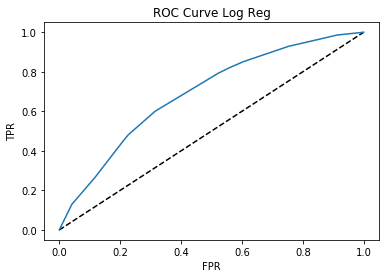

In [307]:
#going to plow ROC curve
from sklearn.metrics import roc_curve
y_pred_prob = Lr.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Log Reg')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve Log Reg')
plt.show()
#ROC curve of logression we can see that curve is not on the line so has some predictive value, but not perfect model, which makes sense because there were some misclassifications

In [308]:
#going to also retrieve AUC score on model- larger area under curve = better model
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred_prob)
#we can see that area under curve is 70 so fairly moderate model 

0.6900977889884228

# Conclusion
Based on the modeling above, it seems that the city, phone, and if the use is an ultimate black user does play a role in predicting the retention of the user. Ultimate can use this information to increase advertisements in those respective areas, such as increase metro ads to ultimate members to increase retention or in areas such as Winterfell that had high retained users. I think as follow-ups some useful information would be age of rider and intent. Many people may utilize this ride service for work rather than pleasure or vice versa. It would be helpful to paint a better picture of the demographic to further see what factors are most important. 